In [2]:
import pandas as pd
import numpy as np
from string import punctuation
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction import text
from sklearn.preprocessing import PowerTransformer
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

In [3]:
plt.style.use('ggplot')

plt.rcParams['lines.markersize'] = 10
plt.rcParams['font.size'] =17
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams[ 'figure.dpi']= 100
plt.rcParams['axes.titlepad']= 15.0
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['xtick.labelsize'] ='small'

plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1

plt.rcParams['lines.color'] = 'b'

In [4]:
def ax_labels(ax, x='', y='', title=''):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)
    return ax

# Content based recommender

## Now, we will look at similarities between trails to give recommendation to users who have liked specific trails

## I will build two recommenders
        1. Based on short description/long description/tags:
        2. Based on features such as duration, elevation, difficulty, etc

## 1. Description based recommender

In [5]:
df = pd.read_csv('../../csv/combined/CA_trails.csv')
df.head(1)

,name,stars,review_count,location,elevation,route_type,short_description,long_description,tag_list,n_photos,n_recordings,n_completed,state,State,difficulty,short,long,n_tags,distance,duration
0,Vernal and Nevada Falls via the Mist Trail,5.0,2870,Yosemite National Park,2191.0,Loop,Vernal and Nevada Falls via the Mist Trail is ...,Yosemite National Park charges a fee to enter....,"['Hiking', 'Forest', 'Partially paved', 'River...",7461,1521,13298,california,CA,3,260,1,13,8.8,301.0


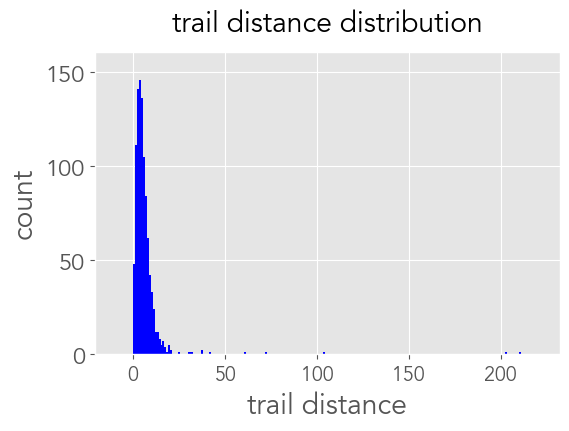

In [6]:
ax = df['distance'].hist(bins=200, color = "blue")
ax_labels(ax, 'trail distance', 'count','trail distance distribution')

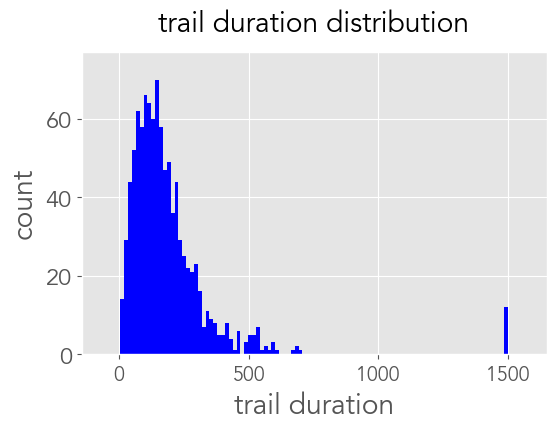

In [7]:
ax= df['duration'].hist(bins=100,color = "blue")
ax = ax_labels(ax, 'trail duration', 'count','trail duration distribution')

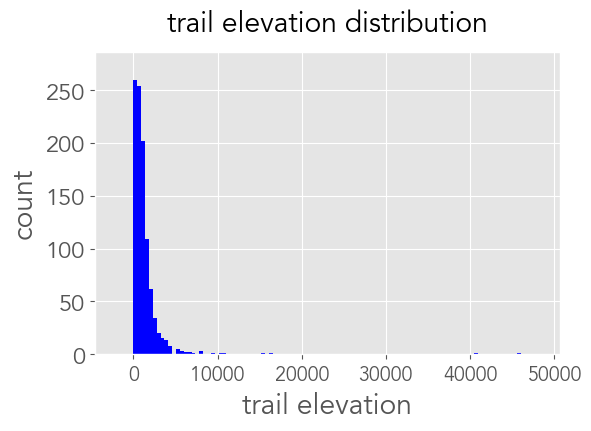

In [8]:
ax = df['elevation'].hist(bins=100, color = "blue")
ax = ax_labels(ax, 'trail elevation', 'count','trail elevation distribution')

## Preprocessing text for NLP

In [9]:
def tag_list_to_text(x):
    chars = ['[', ']', "'", ","]
    test_string = ''.join(i for i in x if not i in chars)
    return test_string

In [10]:
def lower_case(x):
    result = ' '.join(word.lower() for word in x.split(' '))
    return result

def remove_numbers(x):
    result = ''.join(word for word in x if not word.isdigit())
    return result

def remove_nl(x):
    result = x.replace('\n','')
    return result

def strip_punctuation(s):
    return ''.join(c for c in str(s) if c not in punctuation)

stopword = stopwords.words('english')

def remove_stopwords(x):
    result = ' '.join(word for word in x.split(' ') if word not in stopword)
    return result

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    result = ' '.join(wordnet_lemmatizer.lemmatize(word) for word in x.split(' '))
    return result

snowball_stemmer = SnowballStemmer('english')

def stem(x):
    result = ' '.join(snowball_stemmer.stem(word) for word in x.split(' '))
    return result

In [11]:
## Create indice for trail_id and trail name pair
df = df.reset_index()
name = df['name']
indices = pd.Series(df.index, index=df['name'])

In [12]:
## Create text corpus for feature based recommender
df['tag_words'] = df['tag_list'].apply(tag_list_to_text)
df['descriptions'] = df['short_description'] + df['long_description'] + df['tag_words']
df['cleaned_descriptions'] = df['descriptions'].apply(strip_punctuation).apply(remove_nl).apply(lower_case).apply(remove_numbers).apply(strip_punctuation).apply(remove_stopwords)  .apply(lemmatize).apply(stem)       

## Creat countvectorizer 
CV = CountVectorizer()     ## CV is a dict with all the words in the corpus and an index value for each word
Y = CV.fit_transform(df['cleaned_descriptions'].astype('U'))   # The whole corpus is fit in order to give sparse matrix with number of times the word is used

## Create TF-IDF matrix
tf = TfidfVectorizer(ngram_range=(1, 2))
tfidf_matrix = tf.fit_transform(df['cleaned_descriptions'].astype('U'))
idf_values = dict(zip(tf.get_feature_names(), tf.idf_))

## Create cosine similarty matrix 
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [13]:
tf_words = tf.get_feature_names()

In [14]:
## For seven falls
A= tfidf_matrix[53].todense()
A = np.asarray(A).reshape(-1)
idx = (-A).argsort()[:50]
[tf_words[i] for i in idx]

['moro',
 'el moro',
 'el',
 'moro canyon',
 'canyon',
 'coastlin view',
 'best coastlin',
 'line youll',
 'moro visitor',
 'ridg sweep',
 'loop give',
 'youll enjoy',
 'elev ridg',
 'sweep coastal',
 'tour el',
 'traila trail',
 'climb elev',
 'end el',
 'center loop',
 'fee kid',
 'give tour',
 'canyon climb',
 'enjoy best',
 'moro ridg',
 'take canyon',
 'coastal view',
 'ridg line',
 'canyon moro',
 'ridg',
 'beach',
 'trail',
 'begin end',
 'view park',
 'laguna beach',
 'loop',
 'park park',
 'sweep',
 'near laguna',
 'coastlin',
 'beach partial',
 'laguna',
 'tour',
 'traila',
 'use traila',
 'yearround hors',
 'canyon loop',
 'muddi rocki',
 'beach california',
 'give',
 'fee']

In [15]:
for trail in hs:
    A= tfidf_matrix[trail].todense()
    A = np.asarray(A).reshape(-1)
    idx = (-A).argsort()[:10]
    print([tf_words[i] for i in idx])

NameError: name 'hs' is not defined

In [ ]:
for trail in ts:
    A= tfidf_matrix[trail].todense()
    A = np.asarray(A).reshape(-1)
    idx = (-A).argsort()[:15]
    print([tf_words[i] for i in idx])

In [ ]:
A[idx]

In [ ]:
word_list = CV.get_feature_names();    
count_list = Y.toarray().sum(axis=0)    
d = dict(zip(word_list,count_list))

sorted_dictionary = {k: v for k, v in sorted(d.items(), reverse=True, key=lambda item: item[1])}

l = list(sorted_dictionary)
x = list(sorted_dictionary.keys())[:40]
y = list(sorted_dictionary.values())[:40]

fig, ax = plt.subplots(figsize=(25,5))

plt.bar(x,y, color='g')
ax.set_xticklabels(x, rotation = 90) 

In [ ]:
tfidf_matrix[53].todense()

In [ ]:
idf_values = dict(zip(tf.get_feature_names(), tf.idf_))

sorted_dictionary = {k: v for k, v in sorted(idf_values.items(), reverse=True, key=lambda item: item[1])}

l = list(sorted_dictionary)
x = list(sorted_dictionary.keys())[:40]
y = list(sorted_dictionary.values())[:40]

fig, ax = plt.subplots(figsize=(25,5))

plt.bar(x,y, color='g')
ax.set_xticklabels(x, rotation = 90) 

In [16]:
def get_recommendations_by_text_sim(idx, top_n):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1],  reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    trail_indices = [i[0] for i in sim_scores]
    result = df.iloc[trail_indices][{'name','duration','distance','elevation','difficulty','stars','tag_list','location'}]
    return result

## 2. Feature based recommender

### Features to be used: elevation, duration, difficulty, distance, route_type

In [17]:
## Create feature matrix with trail stats
feature_matrix = df[{'elevation', 'duration', 'difficulty', 'distance', 'route_type'}]
dummies = pd.get_dummies(feature_matrix['route_type'])
feature_matrix = pd.concat([feature_matrix, dummies], axis=1)
feature_matrix.drop(columns={'route_type'}, inplace=True)
feature_matrix[feature_matrix['duration'].isna()]

## First drop the trails with missing duration
feature_matrix_new = feature_matrix.drop([214, 222,707])

## Build knn model to predict and fill in the durations for trails above
X_train = feature_matrix_new.drop(columns={'duration'})
y_train = feature_matrix_new['duration']

X_test = feature_matrix[feature_matrix['duration'].isna()]
X_test = X_test.drop(columns={'duration'})

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train,y_train)
pred_duration = neigh.predict(X_test)

feature_matrix['duration'].iloc[[214,222,707]] = pred_duration

/Users/eunheelim/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
## Raw cosine_similarity
raw_feature_cosine_sim = cosine_similarity(feature_matrix, feature_matrix)

## Cosine similarty from features transformed with powertransformer 
PT = PowerTransformer()
PT.fit(feature_matrix)
PT_matrix = PT.transform(feature_matrix)
PT_feature_cosine_sim = (cosine_similarity(PT_matrix, PT_matrix)+1)/2

In [19]:
def get_recommendations_by_feature_sim(idx, top_n):
    sim_scores = list(enumerate(PT_feature_cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1],  reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    trail_indices = [i[0] for i in sim_scores]
    result = df.iloc[trail_indices][{'name','duration','distance','elevation','difficulty','stars','tag_list','location'}]
    return result

In [20]:
#np.savetxt('web_app/examples/data/feature_sim.txt',PT_feature_cosine_sim, delimiter = ',')
#np.savetxt('web_app/examples/data/text_sim.txt', cosine_sim, delimiter = ',')

## Hybrid content based recommender from text and stats

In [21]:
def get_recommendations_by_hybrid_sim(idx, top_n):
    hybrid_cosine_sim = 0.45*PT_feature_cosine_sim + 0.55*cosine_sim
    sim_scores = list(enumerate(hybrid_cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1],  reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    trail_indices = [i[0] for i in sim_scores]
    result = df.iloc[trail_indices][{'name','duration','distance','elevation','difficulty','stars','tag_list','location'}]
    return result

## Test out performance

## Compare performance of content similaity based recommernders by giving top n recommendations and comparing the average cosine similarity value

In [22]:
order = ['name', 'location', 'stars', 'distance', 'duration', 'elevation', 'difficulty', 'tag_list']

In [23]:
df[df.index==53][order]

,name,location,stars,distance,duration,elevation,difficulty,tag_list
53,El Moro Canyon Loop Trail,Crystal Cove State Park,4.5,5.0,153.0,807.0,2,"['Kid friendly', 'Hiking', 'Horseback riding',..."


In [24]:
get_recommendations_by_feature_sim(570,5)[order]

,name,location,stars,distance,duration,elevation,difficulty,tag_list
675,Five Oaks Trail,Volcan Mountain Wilderness Preserve,4.5,3.2,112.0,859.0,2,"['Dogs on leash', 'Hiking', 'Nature trips', 'W..."
104,Crystal Lake Trail,Inyo National Forest,4.5,3.1,109.0,833.0,2,"['Dog friendly', 'Kid friendly', 'Fishing', 'H..."
931,Skelton Lake Trail,John Muir Wilderness,5.0,3.1,110.0,872.0,2,"['Dogs on leash', 'Hiking', 'Nature trips', 'W..."
702,Little Baldy Trail,Sequoia National Park,5.0,3.3,112.0,793.0,2,"['Hiking', 'Nature trips', 'Walking', 'Bird wa..."
77,Stonewall Peak Trail,Cuyamaca Rancho State Park,4.5,3.4,115.0,813.0,2,"['Kid friendly', 'Hiking', 'Nature trips', 'Ro..."


In [25]:
get_recommendations_by_text_sim(570,5)[order]

,name,location,stars,distance,duration,elevation,difficulty,tag_list
671,Ortega Falls,Cleveland National Forest,4.0,0.2,5.0,39.0,2,"['Dogs on leash', 'Kid friendly', 'Hiking', 'R..."
383,Jesusita Trail,Los Padres National Forest,4.5,6.8,228.0,1574.0,2,"['Dog friendly', 'Hiking', 'Mountain biking', ..."
41,Escondido Falls Trail,Escondido Canyon Park,4.0,3.7,115.0,626.0,1,"['Dogs on leash', 'Kid friendly', 'Hiking', 'M..."
37,"Castle Rock, Saratoga Gap and Ridge Trail Loop",Castle Rock State Park,4.5,12.4,359.0,2237.0,2,"['Kid friendly', 'Backpacking', 'Camping', 'Hi..."
581,Grasslands Loop Trail,Mission Trails Regional Park,4.5,4.3,120.0,403.0,2,"['Dogs on leash', 'Kid friendly', 'Hiking', 'N..."


In [26]:
get_recommendations_by_hybrid_sim(570,5)[order]

,name,location,stars,distance,duration,elevation,difficulty,tag_list
537,Mill Creek Falls Trail,Lassen Volcanic National Park,4.5,3.8,123.0,780.0,2,"['Kid friendly', 'Hiking', 'Nature trips', 'Wa..."
680,Backbone Trail to Sandstone Peak,Santa Monica Mountains National Recreation Area,4.5,3.2,119.0,1030.0,2,"['Dogs on leash', 'Kid friendly', 'Hiking', 'M..."
55,Trail Canyon Falls,Angeles National Forest,4.5,4.8,159.0,1053.0,2,"['Dogs on leash', 'Backpacking', 'Camping', 'H..."
298,Murray Canyon Trail to Seven Falls,Santa Rosa and San Jacinto Mountains National ...,4.5,3.7,114.0,600.0,2,"['Kid friendly', 'Hiking', 'Horseback riding',..."
245,Grotto Trail,Santa Monica Mountains National Recreation Area,4.5,2.5,83.0,561.0,2,"['Dogs on leash', 'Kid friendly', 'Camping', '..."


In [175]:
ts = [671,383,41,37,581]
hs = [537,680,55,298,245]

In [185]:
df[df['name'].str.contains('Moro')]

,index,name,stars,review_count,location,elevation,route_type,short_description,long_description,tag_list,...,State,difficulty,short,long,n_tags,distance,duration,tag_words,descriptions,cleaned_descriptions
34,34,Moro Rock Trail,4.5,1086,Sequoia National Park,187.0,Out & Back,Moro Rock Trail is a 0.4 mile heavily traffick...,Sequoia National Park charges a fee to enter. ...,"['Hiking', 'Nature trips', 'Rock climbing', 'W...",...,CA,2,250,1,13,0.4,17.0,Hiking Nature trips Rock climbing Walking Bird...,Moro Rock Trail is a 0.4 mile heavily traffick...,moro rock trail mile heavili traffick back tr...
53,53,El Moro Canyon Loop Trail,4.5,1601,Crystal Cove State Park,807.0,Loop,El Moro Canyon Loop Trail is a 5 mile heavily ...,A trail that takes you through canyon and up t...,"['Kid friendly', 'Hiking', 'Horseback riding',...",...,CA,2,284,1,16,5.0,153.0,Kid friendly Hiking Horseback riding Mountain ...,El Moro Canyon Loop Trail is a 5 mile heavily ...,el moro canyon loop trail mile heavili traffi...
429,429,El Moro Canyon Short Loop Trail,4.5,539,Crystal Cove State Park,479.0,Loop,El Moro Canyon Short Loop Trail is a 2.9 mile ...,"Ocean views, insulated canyon, coast chaparral...","['Kid friendly', 'Hiking', 'Horseback riding',...",...,CA,2,291,1,15,2.9,89.0,Kid friendly Hiking Horseback riding Mountain ...,El Moro Canyon Short Loop Trail is a 2.9 mile ...,el moro canyon short loop trail mile heavili ...
524,524,Moro Ridge Spur to Moro Ridge Road,4.5,395,Crystal Cove State Park,846.0,Out & Back,Moro Ridge Spur to Moro Ridge Road is a 4.7 mi...,NaN,"['Kid friendly', 'Hiking', 'Nature trips', 'Ru...",...,CA,2,254,0,8,4.7,148.0,Kid friendly Hiking Nature trips Running Views...,NaN,nan
665,665,El Moro Canyon to Moro Ridge Loop,4.5,289,Crystal Cove State Park,1072.0,Loop,El Moro Canyon to Moro Ridge Loop is a 8 mile ...,NOTE: Parking fee is $15.\r\n\r\n,"['Backpacking', 'Camping', 'Hiking', 'Mountain...",...,CA,2,265,1,12,8.0,237.0,Backpacking Camping Hiking Mountain biking Nat...,El Moro Canyon to Moro Ridge Loop is a 8 mile ...,el moro canyon moro ridg loop mile heavili tr...
724,724,"B.F.I., Moro Ridge Spur, Poles Loop",4.5,493,Crystal Cove State Park,1059.0,Loop,"B.F.I., Moro Ridge Spur, Poles Loop is a 4.8 m...",NaN,"['Hiking', 'Mountain biking', 'Nature trips', ...",...,CA,2,256,0,9,4.8,159.0,Hiking Mountain biking Nature trips Walking Bi...,NaN,nan


In [30]:
df[df.index==53][order].append(get_recommendations_by_hybrid_sim(53,5)[order])

,name,location,stars,distance,duration,elevation,difficulty,tag_list
53,El Moro Canyon Loop Trail,Crystal Cove State Park,4.5,5.0,153.0,807.0,2,"['Kid friendly', 'Hiking', 'Horseback riding',..."
665,El Moro Canyon to Moro Ridge Loop,Crystal Cove State Park,4.5,8.0,237.0,1072.0,2,"['Backpacking', 'Camping', 'Hiking', 'Mountain..."
429,El Moro Canyon Short Loop Trail,Crystal Cove State Park,4.5,2.9,89.0,479.0,2,"['Kid friendly', 'Hiking', 'Horseback riding',..."
48,Claremont Hills Wilderness Trail,Claremont Hills Wilderness Park,4.5,4.7,148.0,846.0,2,"['Dog friendly', 'Kid friendly', 'Hiking', 'Ho..."
150,Seaview and Big Springs Trails Loop,Tilden Regional Park,4.5,4.3,144.0,984.0,2,"['Dog friendly', 'Kid friendly', 'Hiking', 'Ho..."
971,Shell Ridge - Borgess Ranch Loop,Shell Ridge Open Space,4.5,4.7,141.0,685.0,2,"['Dog friendly', 'Kid friendly', 'Hiking', 'Ho..."
